In [1]:
CODE_DIR = "/home/cbarkhof/fall-2021"

import sys
sys.path.append(CODE_DIR)

In [2]:
import os

%config InlineBackend.figure_format='retina'
%matplotlib inline

import pickle
import pandas

import random
import matplotlib.pyplot as plt

import numpy as np
from tqdm.auto import tqdm



import torch
import torch.nn.functional as F
from torch.distributions import constraints
import torch.distributions  as td

import pyro
import pyro.distributions as pd
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import config_enumerate, infer_discrete

from pyro.optim import ClippedAdam
from pyro import poutine

assert pyro.__version__.startswith('1.6.0')
pyro.set_rng_seed(0)

from tabulate import tabulate
from collections import namedtuple, OrderedDict

import torch_two_sample as tts

device = torch.device('cuda:0')

def moving_average(data_set, periods=3):
    weights = np.ones(periods) / periods
    return np.convolve(data_set, weights, mode='valid')

# My imports
from analysis.MNIST_analysis.analysis_utils import get_n_data_samples_x_y
from analysis.MNIST_analysis.analysis_plots import plot_latents
from utils import load_checkpoint_model_for_eval

In [3]:
from analysis.MNIST_analysis.analysis_steps import make_run_overview_df

prefixes = ["(mdr-vae-exp 8 oct)", "(fb-vae-exp 8 oct) ", "(beta-vae-exp 6 oct) ", "(inf-vae-exp 5 oct) "]
run_df = make_run_overview_df(prefixes=prefixes, add_data_group=False)
run_df

,objective,l_rate,beta_beta,free_bits,mdr_value,l_mmd,decoder,run_name
MDR-VAE 40 dec: CNN.T,MDR-VAE,0,0,0,40,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...
MDR-VAE 32 dec: CNN.T,MDR-VAE,0,0,0,32,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=32.0] | q(z|x) ...
MDR-VAE 24 dec: CNN.T,MDR-VAE,0,0,0,24,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=24.0] | q(z|x) ...
MDR-VAE 16 dec: CNN.T,MDR-VAE,0,0,0,16,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=16.0] | q(z|x) ...
MDR-VAE 8 dec: CNN.T,MDR-VAE,0,0,0,8,0,basic_deconv_decoder,(mdr-vae-exp 8 oct) MDR-VAE[R>=8.0] | q(z|x) i...
...,...,...,...,...,...,...,...,...
INFO-VAE l_Rate 100 l_MMD 100 dec: CNN.T,INFO-VAE,100,0,0,0,100,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=100.0, l..."
INFO-VAE l_Rate 1000 l_MMD 1 dec: CNN.T,INFO-VAE,1000,0,0,0,1,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=1000.0, ..."
INFO-VAE l_Rate 100 l_MMD 1000 dec: PixelCNN++,INFO-VAE,100,0,0,0,1000,cond_pixel_cnn_pp,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=100.0, l..."
INFO-VAE l_Rate 1 l_MMD 1000 dec: CNN.T,INFO-VAE,1,0,0,0,1000,basic_deconv_decoder,"(inf-vae-exp 5 oct) INFO-VAE[l_1_rate=1.0, l_2..."


In [4]:
ENCODE_RECONSTUCT_FILE = f"encode-reconstruct-test-valid.pt"
ANALYSIS_DIR = f"{CODE_DIR}/analysis/analysis-files"

SELECT_PHASE = "valid"

all_encodings = dict()

for i, run_name in enumerate(run_df.run_name.values):
    p = f"{ANALYSIS_DIR}/{run_name}/{ENCODE_RECONSTUCT_FILE}"
    encodings = torch.load(p)
    encodings = encodings[SELECT_PHASE]
    if i == 0:
        for k, v in encodings.items(): print(k, v.shape)
    encodings["clean_name"] = run_df[run_df.run_name == run_name].index.values[0]
    all_encodings[run_name] = encodings

z torch.Size([10000, 10])
mean torch.Size([10000, 10])
scale torch.Size([10000, 10])
reconstruct torch.Size([10000, 1, 28, 28])


# Plot latent space

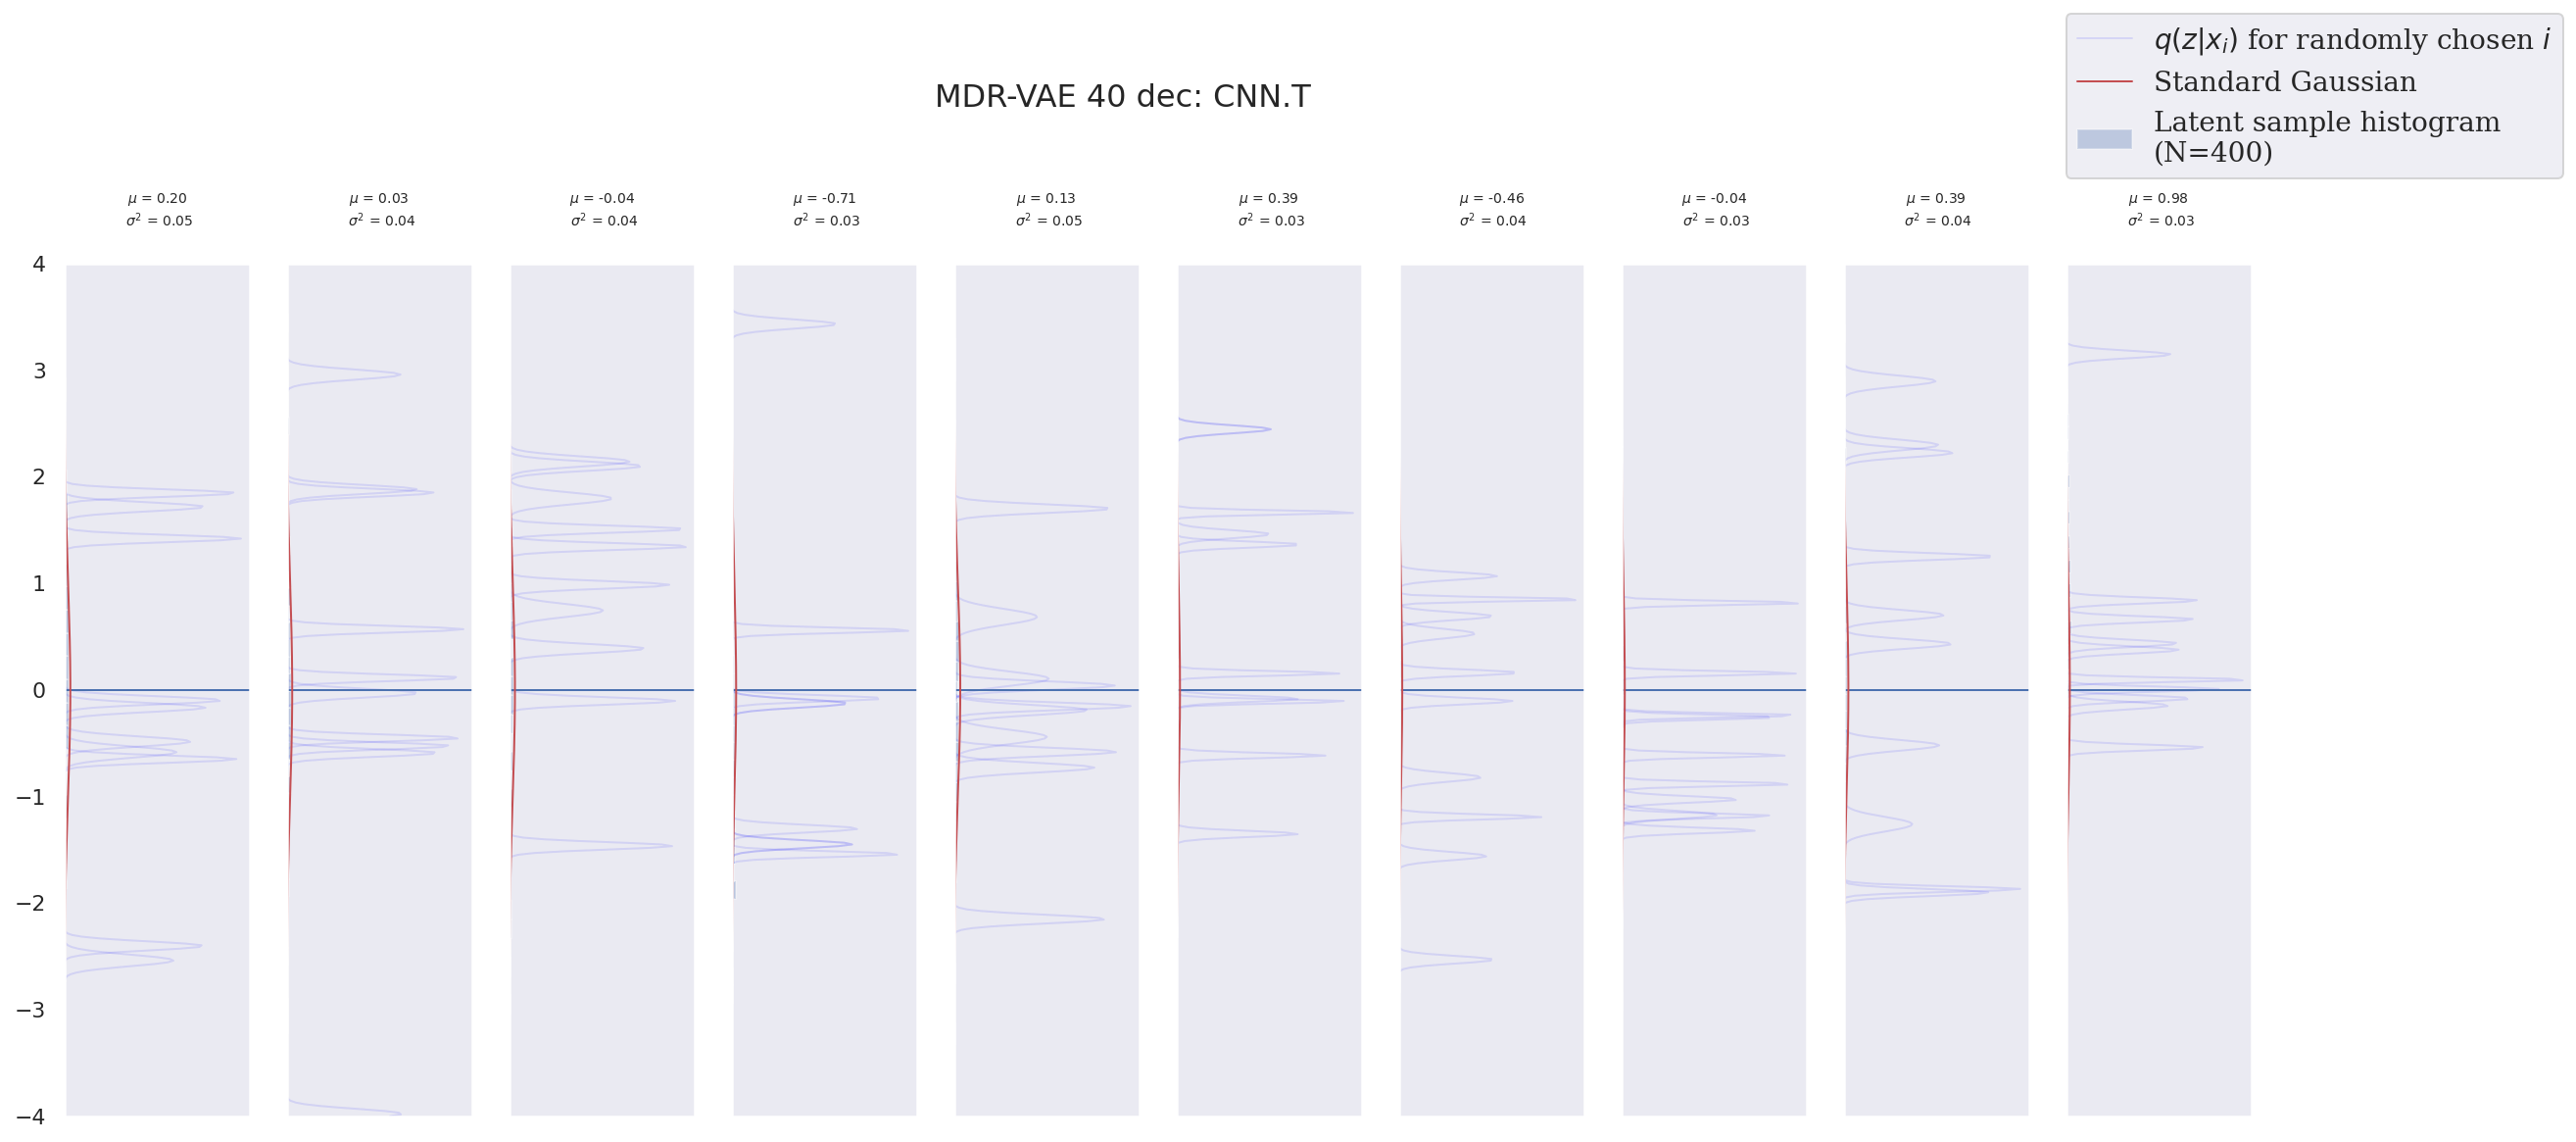

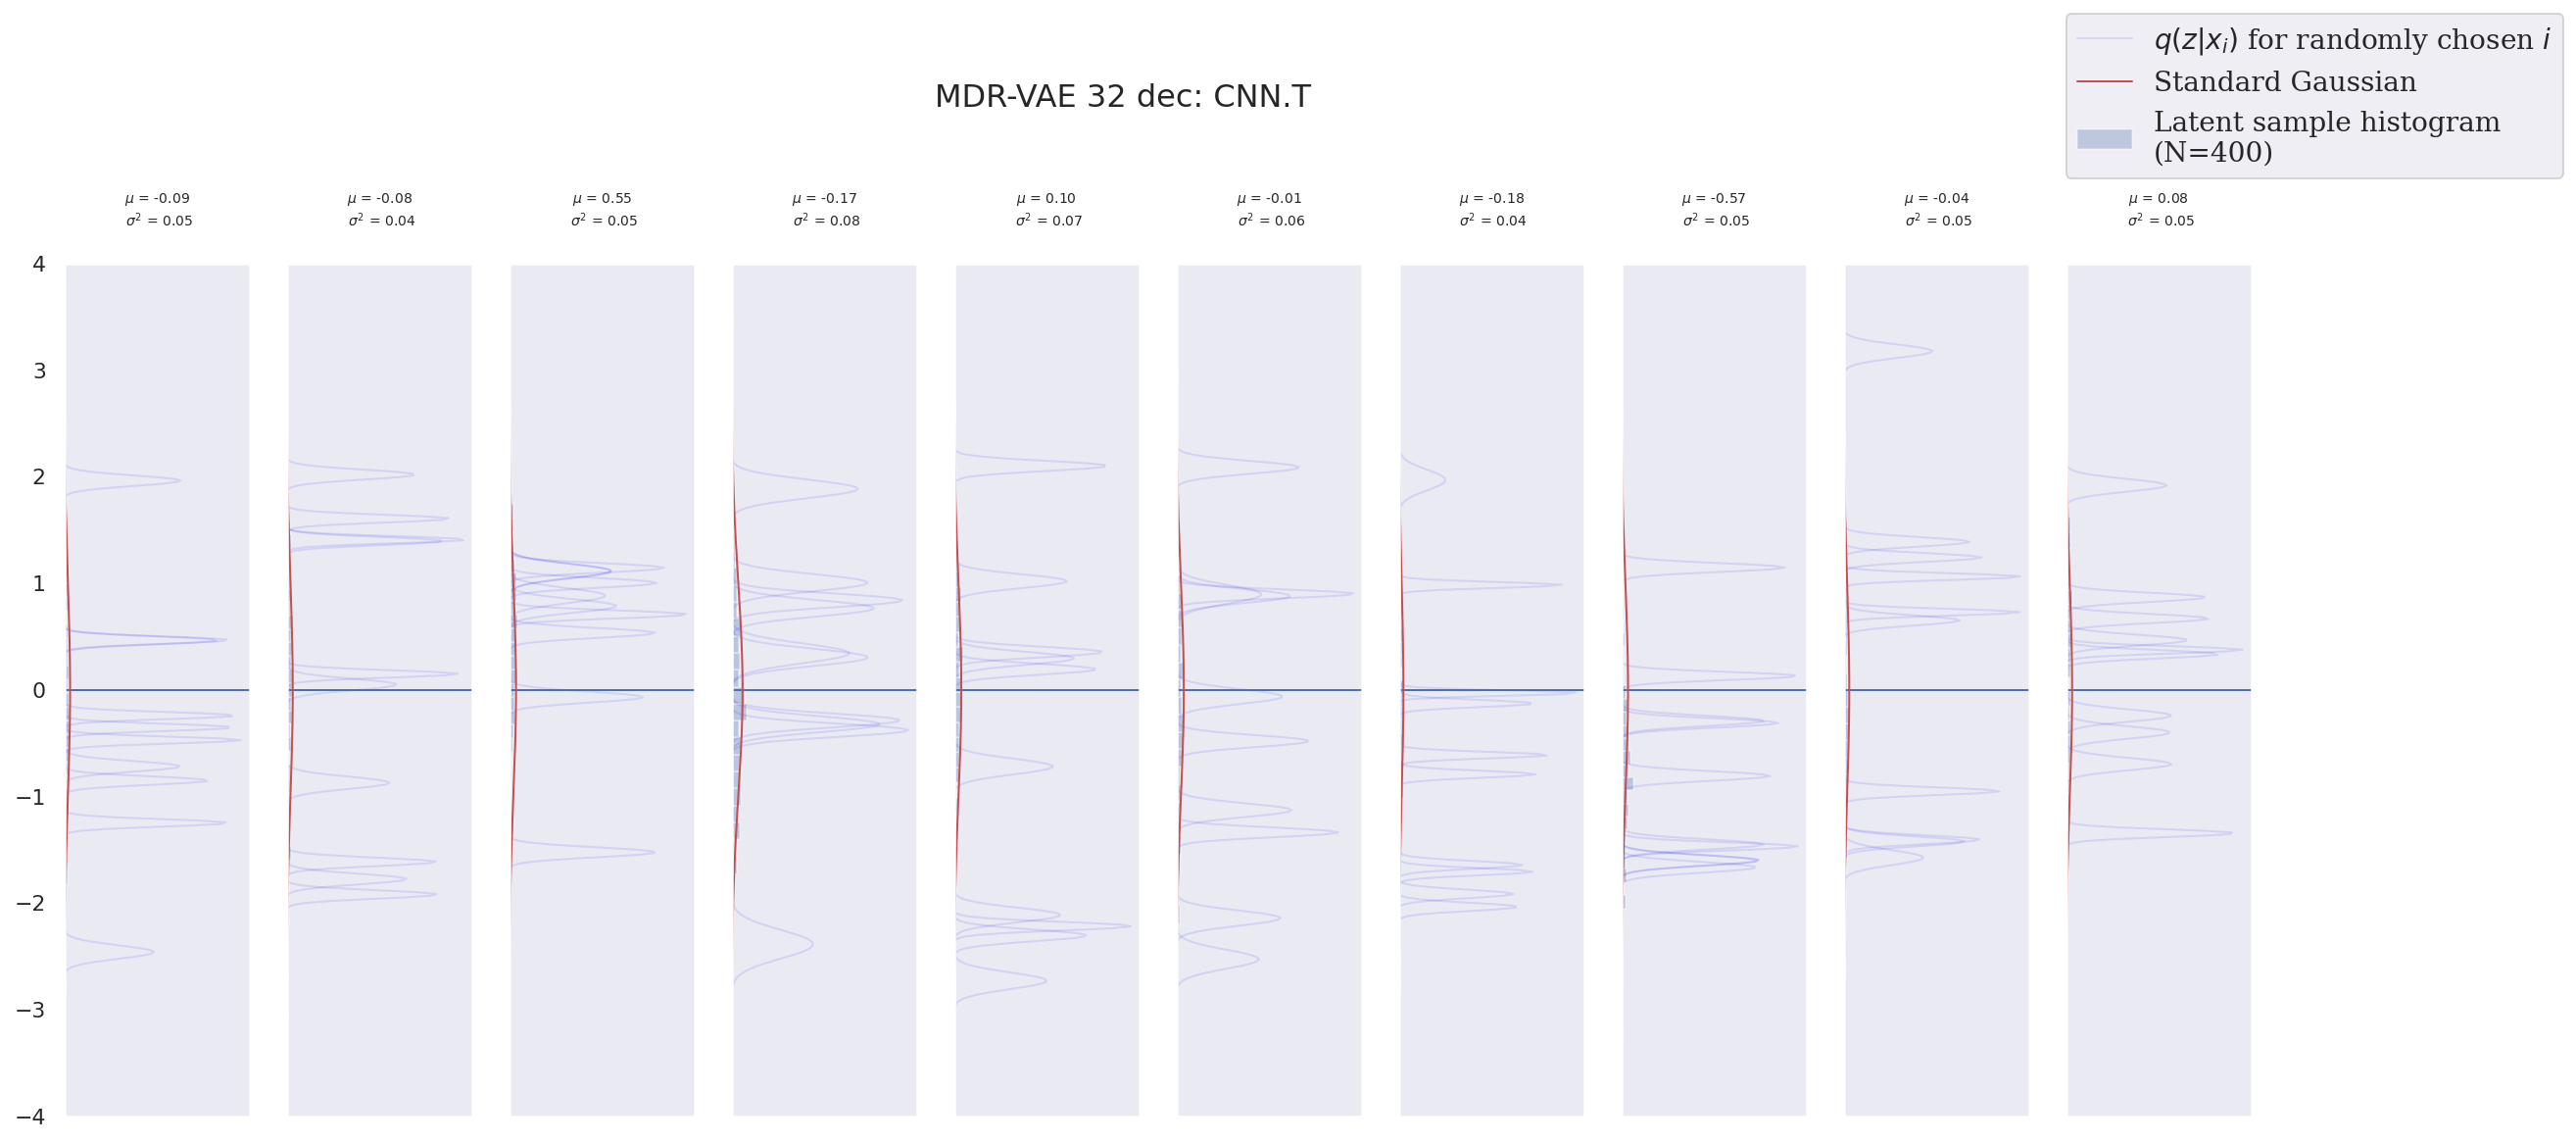

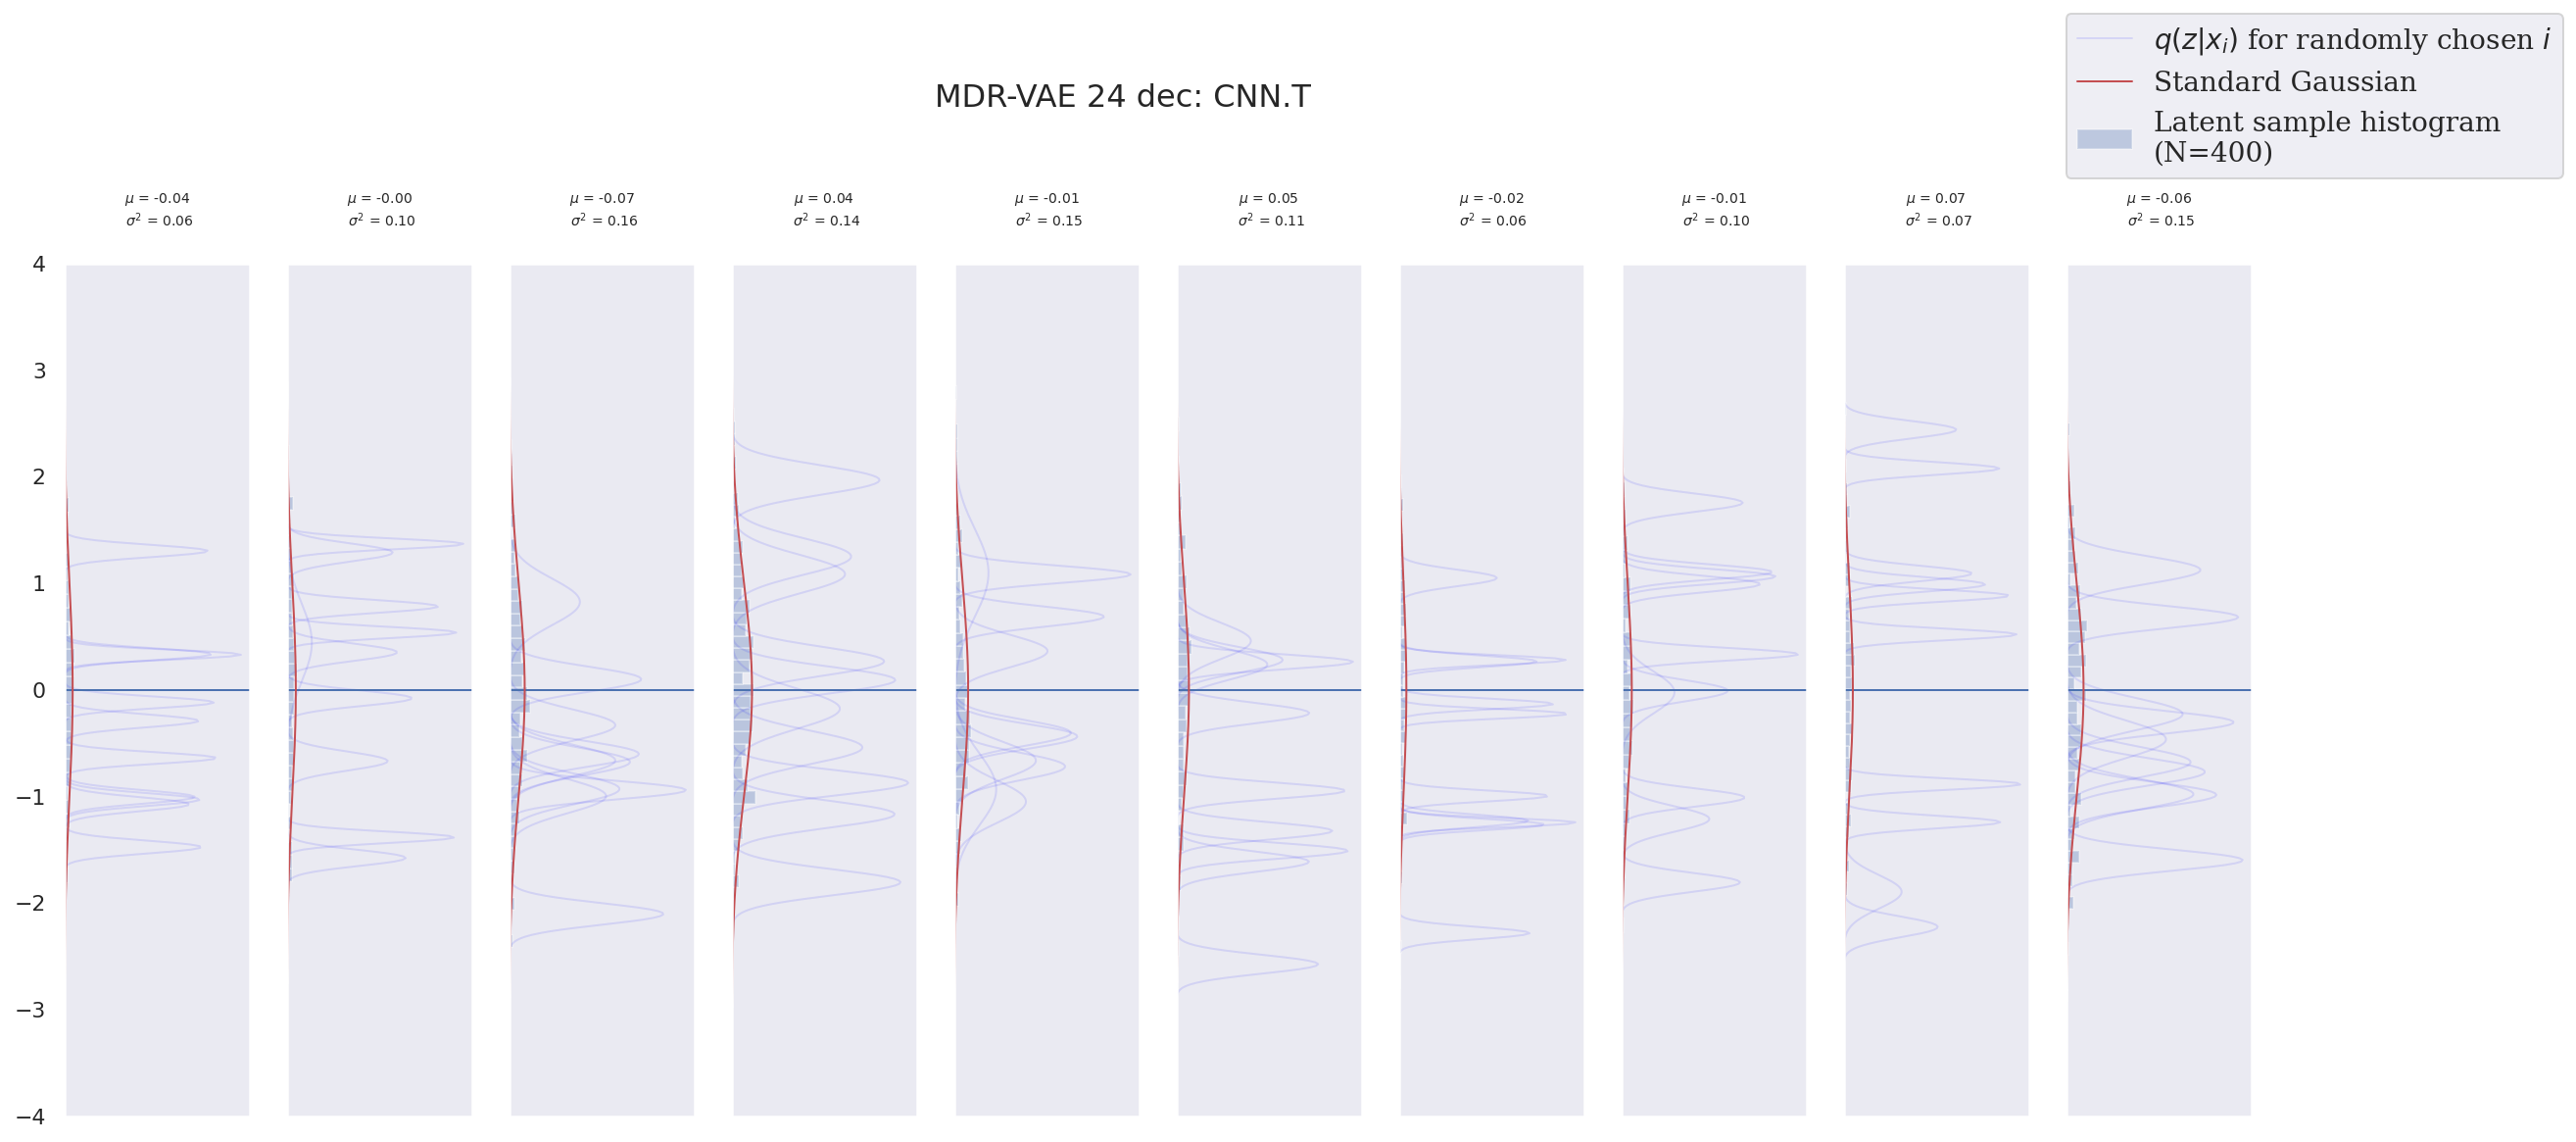

In [5]:
for i, (run_name, encodings) in enumerate(all_encodings.items()):
    
    plot_latents(encodings, encodings["clean_name"], plot_N_sep_posteriors=10, plot_N_encodings=400)
    
    if i == 2: break

# Prepare data for MM analysis

In [6]:
def kl_divergence(mu, std):
    """
    Calculates the KL-divergence between the posterior and the prior analytically.
    """
    
    
    kl_loss = ((mu.pow(2) + std.pow(2)) / 2) - 0.5 - torch.log(std)
    kl_loss = kl_loss.sum(dim=1).mean(dim=0)

    return kl_loss

# N = list(all_encodings.values())[0]["z"].shape[0]
N = 2000
print("N samples", N)

group_names = []
names = []
data_samples = []
locs, scales = [], []
for k, v in all_encodings.items():
    data_samples.append(v["z"][:N])
    locs.append(v["mean"][:N])
    names.append(v["clean_name"])
    scales.append(v["scale"][:N])
    group_names.append(k)

# Prepend standard prior group
data_samples = [torch.randn((N, 10))] + data_samples
group_names = ["prior"] + group_names
names = ["prior"] + names

rates = [0.0] + [kl_divergence(l, s).item() for l, s in zip(locs, scales)]

for i, (n, x) in enumerate(zip(names, data_samples)):
    print(i, n, x.shape, type(x), x.device, end="\n")

N samples 2000
0 prior torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
1 MDR-VAE 40 dec: CNN.T torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
2 MDR-VAE 32 dec: CNN.T torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
3 MDR-VAE 24 dec: CNN.T torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
4 MDR-VAE 16 dec: CNN.T torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
5 MDR-VAE 8 dec: CNN.T torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
6 MDR-VAE 4 dec: CNN.T torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
7 MDR-VAE 40 dec: PixelCNN++ torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
8 MDR-VAE 32 dec: PixelCNN++ torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
9 MDR-VAE 24 dec: PixelCNN++ torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
10 MDR-VAE 16 dec: PixelCNN++ torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
11 MDR-VAE 8 dec: PixelCNN++ torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
12 MDR-VAE 4 dec: PixelCNN++ torch.Size([2000, 10]) <class 'torch.Tensor'> cpu
13 FB-VAE 

In [7]:
S = N
D = 10
data = torch.stack([t.to(device) for t in data_samples])
G = data.shape[0]
print(f"G={G} S={S} D={D}")

G=77 S=2000 D=10


In [8]:
import scipy.stats as st

In [9]:
data.shape

torch.Size([77, 2000, 10])

In [10]:
import torch_two_sample as tts
from tabulate import tabulate

alpha = 0.05

one_sample_stats = []
two_sample_stats = []
mmd_stats = []

alphas = [0.1 * i for i in range(1, 6)]

MMD = tts.statistics_diff.MMDStatistic(data.shape[1], data.shape[1])

table = []

# It's very easy to reject 
for g in range(G):
    # One sample test (against existing, known distribution)
    #print(g, st.kstest(data[g].flatten().cpu().numpy(), 'norm'))
    
    one_sample_ks = st.kstest(data[g].flatten().cpu().numpy(), 'norm')
    
    # Kolmogorov-Smirnov statistic on 2 samples
    two_sample_ks = st.ks_2samp(data[0].flatten().cpu().numpy(), data[g].flatten().cpu().numpy())
    
    mmd = MMD(data[0, :, :], data[g, :, :], alphas=alphas, ret_matrix=False)
    
    mmd_stats.append(mmd.cpu().item())
    one_sample_stats.append(one_sample_ks.statistic)
    two_sample_stats.append(two_sample_ks.statistic)
    
    split = group_names[g].split(" - 2021")[0].split(" ") 
    
    if "prior" in split:
        name = "prior"
    else:
        name = split[1] + "|" + split[3] + "|" + split[6]
    
#     +"\n"
    table.append([name, f"{mmd.cpu().item():.4f}", f"{one_sample_ks.statistic:.4f}", one_sample_ks.pvalue < alpha,  
                  f"{two_sample_ks.statistic:.4f}", two_sample_ks.pvalue < alpha])
#     print(f"Assessing '{group_names[g]}' against null of being Normal with Kolmogorov-Smirnov test")
#     print(f"One sample KS test statistic: {one_sample_ks.statistic:.2f}, rejecting null {one_sample_ks.pvalue < alpha}")
#     print(f"Two sample KS test statistic: {two_sample_ks.statistic:.2f}, rejecting null {two_sample_ks.pvalue < alpha}")
    
#     print()

print(tabulate(table, headers=["name", "TTS mmd", "1 KS", "rej.", "2 KS", "rej."]))


name                                            TTS mmd    1 KS    rej.    2 KS    rej.
--------------------------------------------  ---------  ------  ------  ------  ------
prior                                           -0.0047  0.0079       0  0            0
8|MDR-VAE[R>=40.0]|independent_gaussian          0.1526  0.1045       1  0.1086       1
8|MDR-VAE[R>=32.0]|independent_gaussian          0.0767  0.0587       1  0.0533       1
8|MDR-VAE[R>=24.0]|independent_gaussian          0.0178  0.0221       1  0.0253       1
8|MDR-VAE[R>=16.0]|independent_gaussian          0.0103  0.0121       1  0.0138       1
8|MDR-VAE[R>=8.0]|independent_gaussian           0.0093  0.0119       1  0.0156       1
8|MDR-VAE[R>=4.0]|independent_gaussian           0.0112  0.0163       1  0.0201       1
8|MDR-VAE[R>=40.0]|independent_gaussian          0.1113  0.049        1  0.0524       1
8|MDR-VAE[R>=32.0]|independent_gaussian          0.0198  0.0167       1  0.0136       0
8|MDR-VAE[R>=24.0]|independent_g

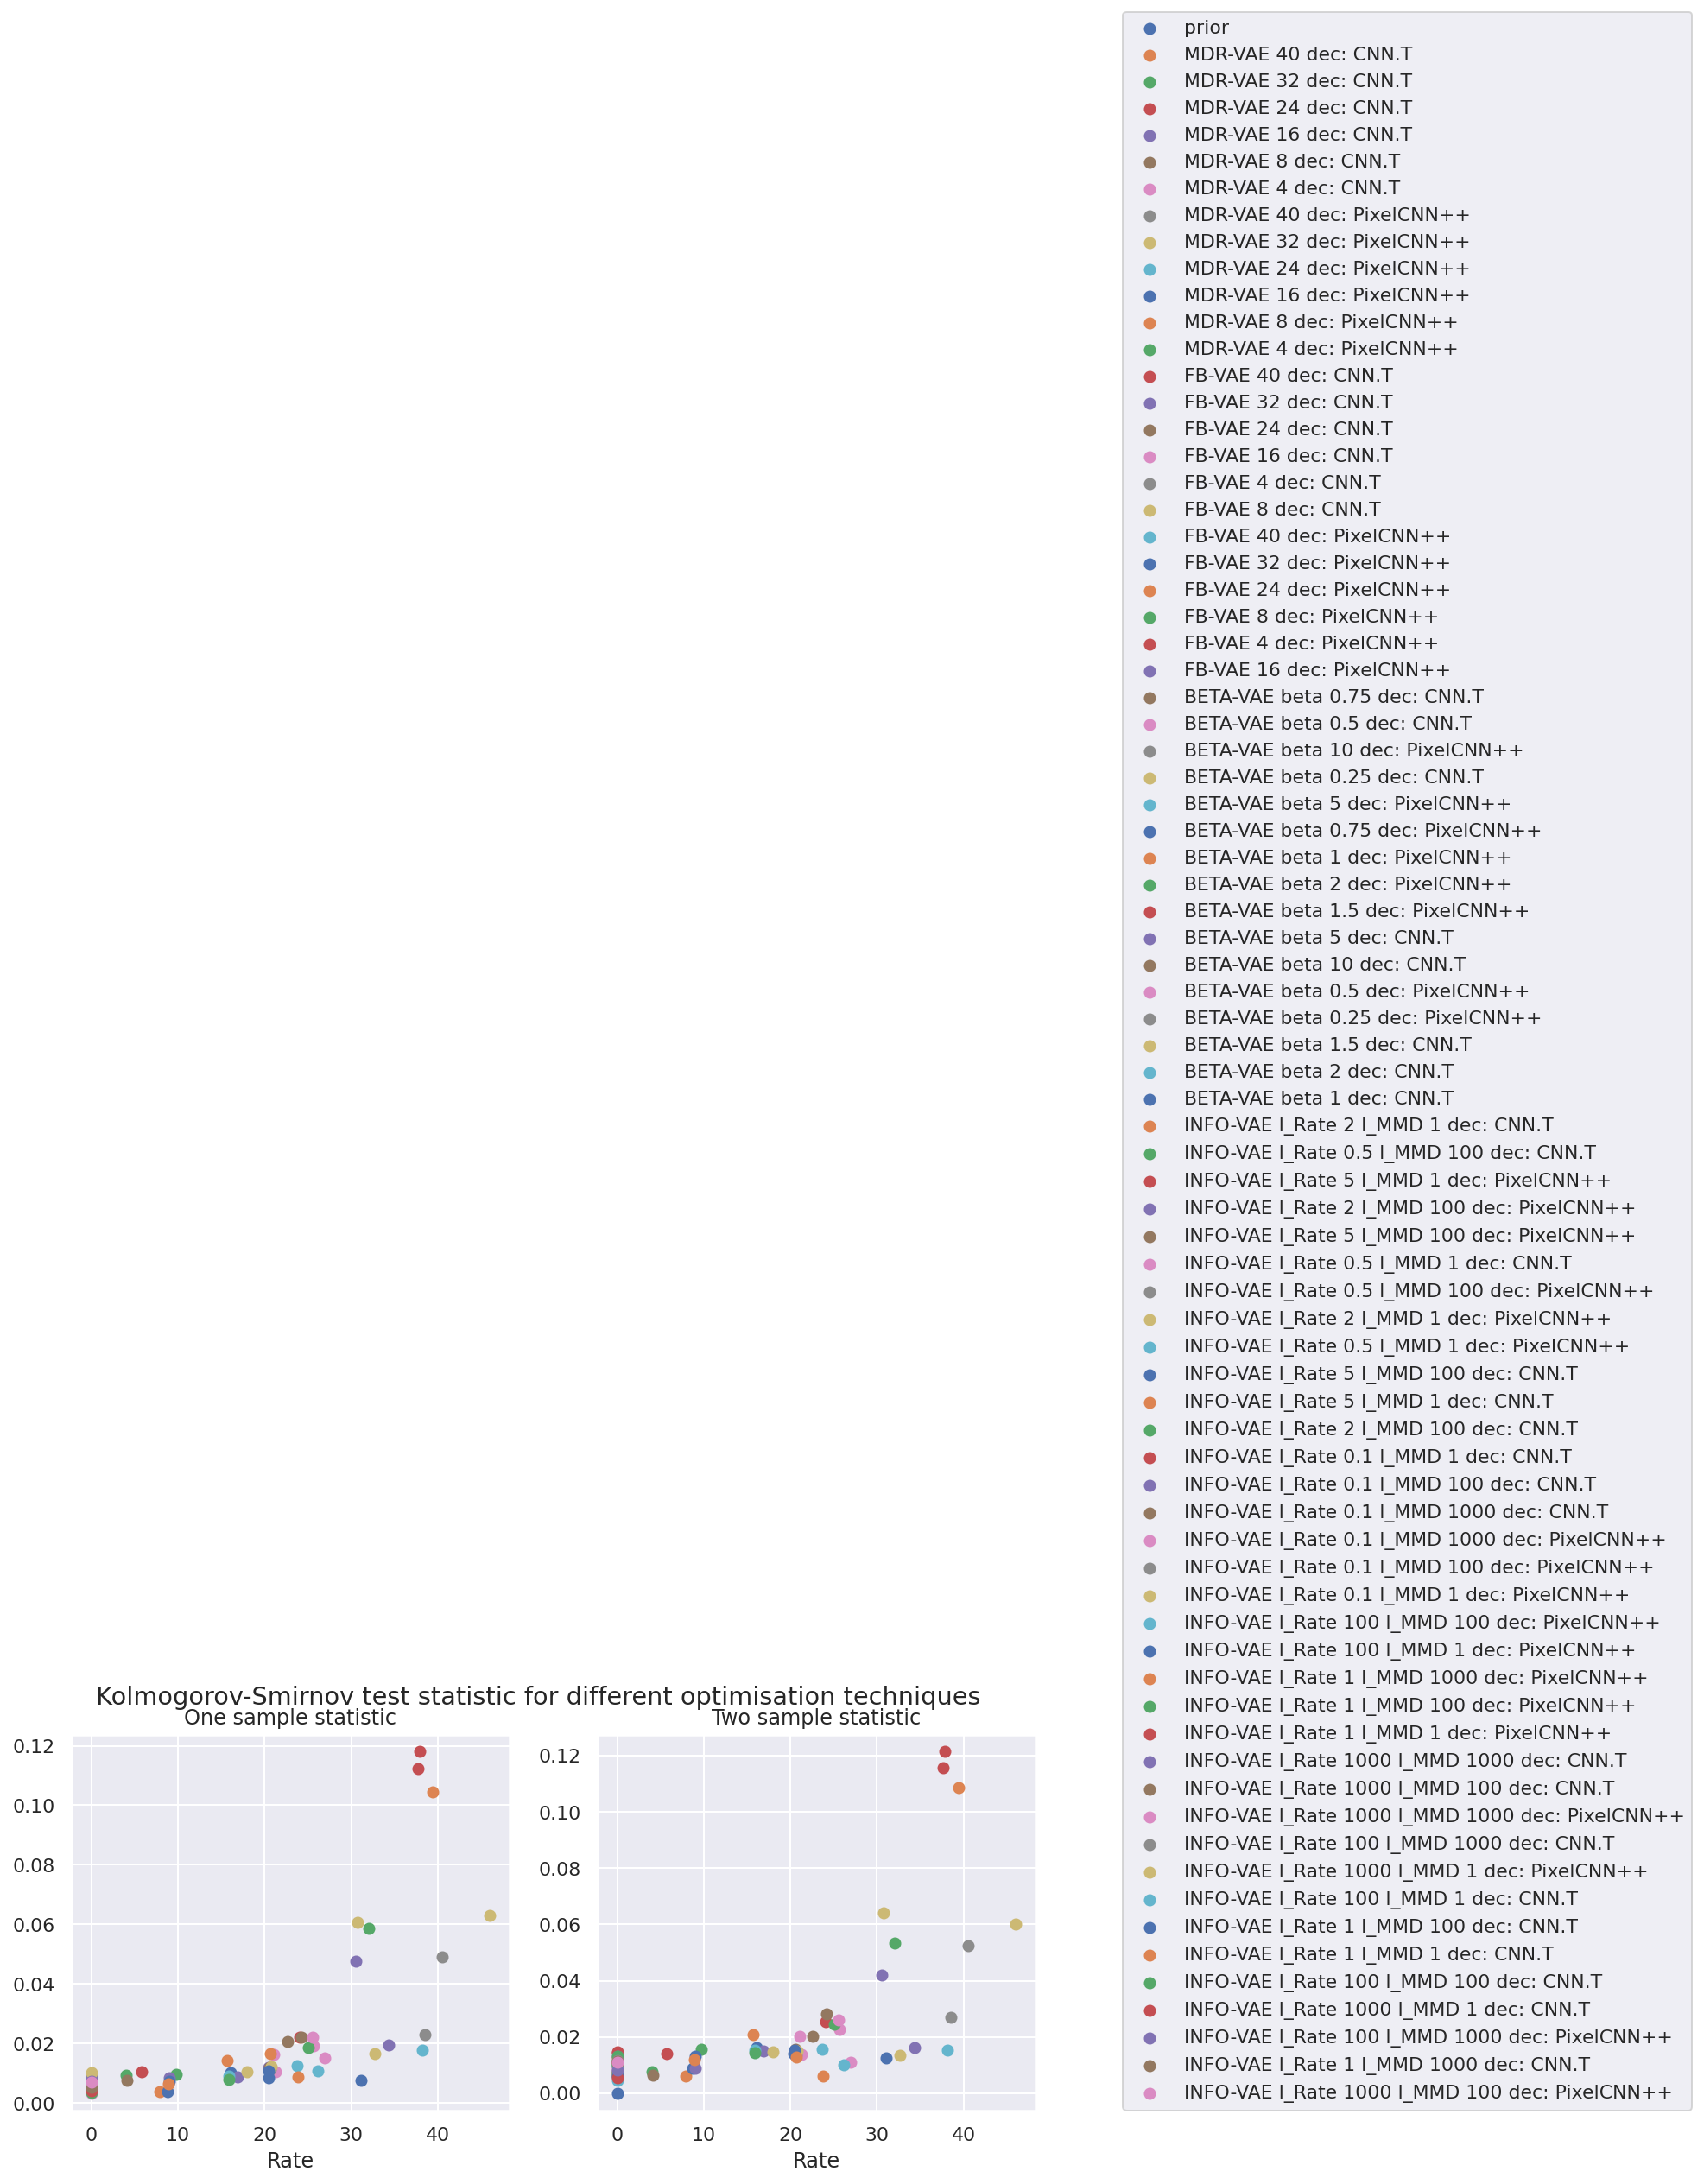

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# colors = ['blue', 'green', 'pink', 'red', 'yellow', 'lightblue', 'black']
# c_dict = {o:colors[i] for i, o in enumerate(list(set(opt_techniques)))}

for g in range(G):
    axs[0].scatter(rates[g], one_sample_stats[g], label=names[g]) #color=c_dict[opt_techniques[g]]
axs[0].set_title("One sample statistic")

for g in range(G):
    axs[1].scatter(rates[g], two_sample_stats[g], label=names[g]) #, color=c_dict[opt_techniques[g]]
axs[1].set_title("Two sample statistic")

axs[0].set_xlabel("Rate")
axs[1].set_xlabel("Rate")

plt.suptitle("Kolmogorov-Smirnov test statistic for different optimisation techniques")
plt.legend(loc=(1.2, 0.0))
plt.show()

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


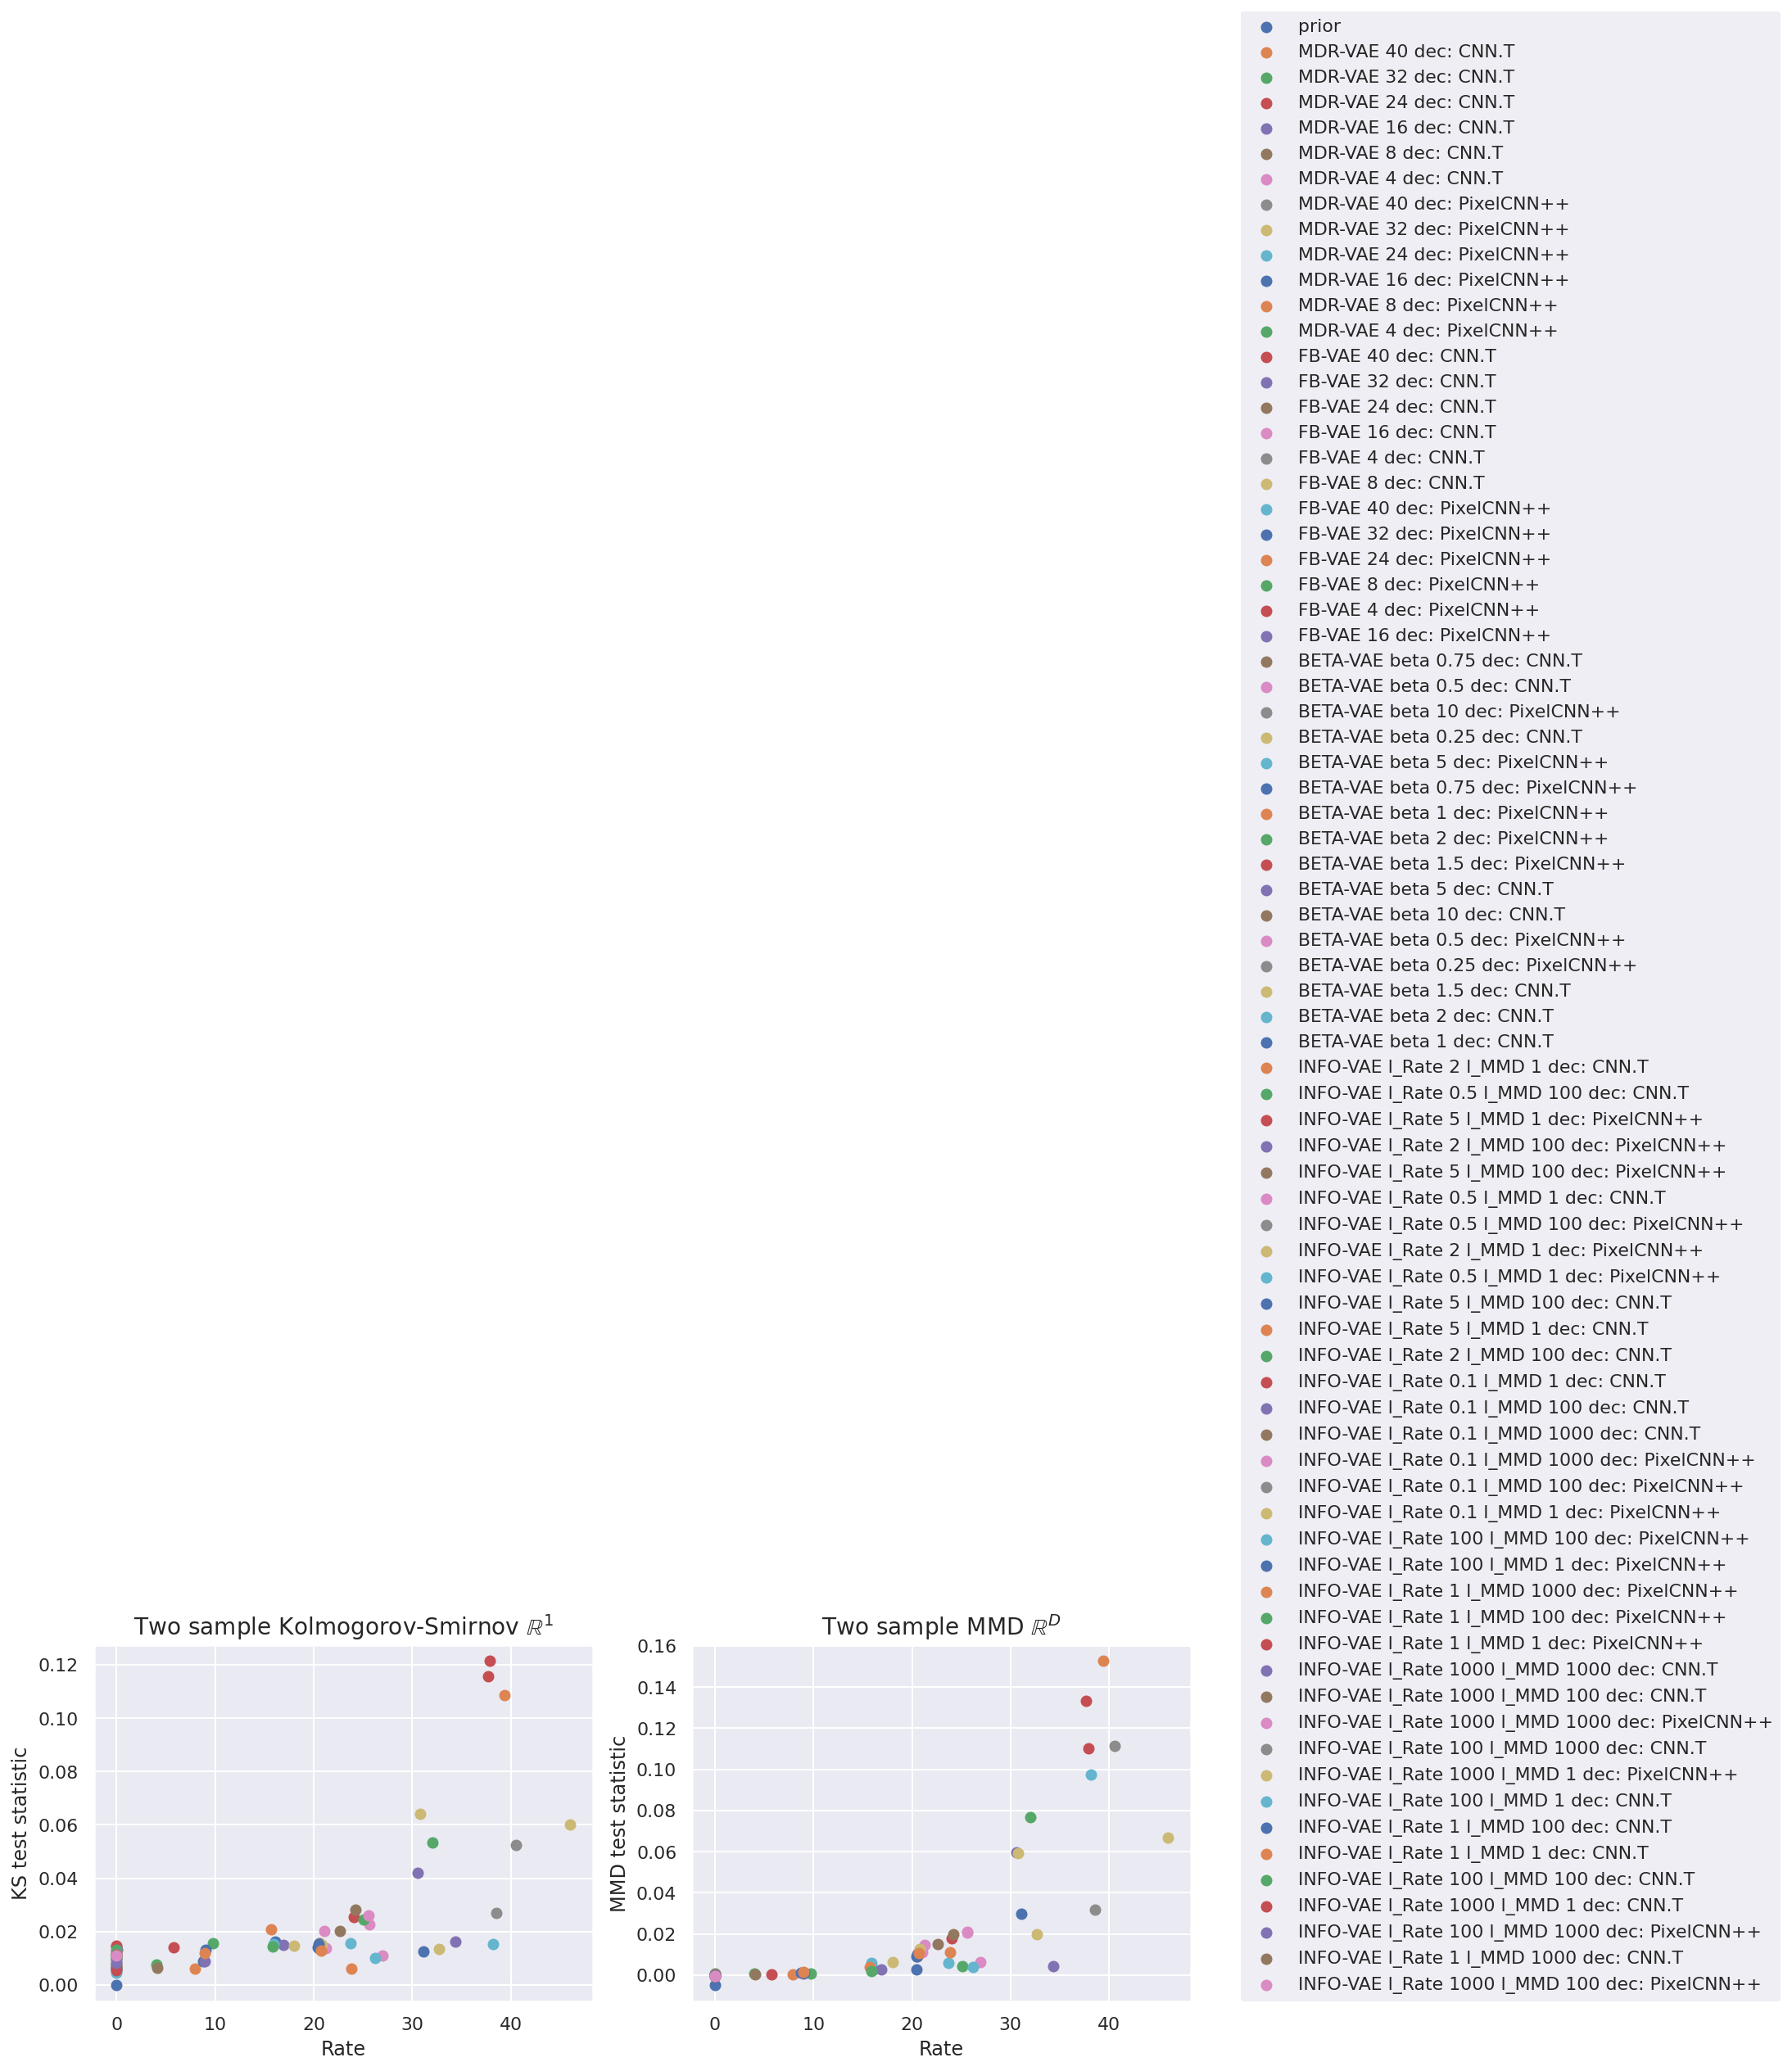

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for g in range(G):
    axs[0].scatter(rates[g], two_sample_stats[g], label=names[g], edgecolors=None)
    plt.sca(axs[0])

axs[0].set_title(r"Two sample Kolmogorov-Smirnov $\mathbb{R}^1$", size=14)
axs[0].set_xlabel("Rate", size=12)
axs[0].set_ylabel("KS test statistic", size=12)

for g in range(G):
    axs[1].scatter(rates[g], mmd_stats[g], label=names[g])

plt.sca(axs[1])
axs[1].set_title("Two sample MMD $\mathbb{R}^D$", size=14)
axs[1].set_xlabel("Rate", size=12)
axs[1].set_ylabel("MMD test statistic", size=12)

leg = plt.legend(loc=(1.1, 0.0))
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()
plt.show()

Sx=2000, G=77, D=10


/home/cbarkhof/fall-2021/analysis/Pyro_BDA/probabll/bda/mmm.py:486: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(groups, device=self.device, dtype=torch.float32)


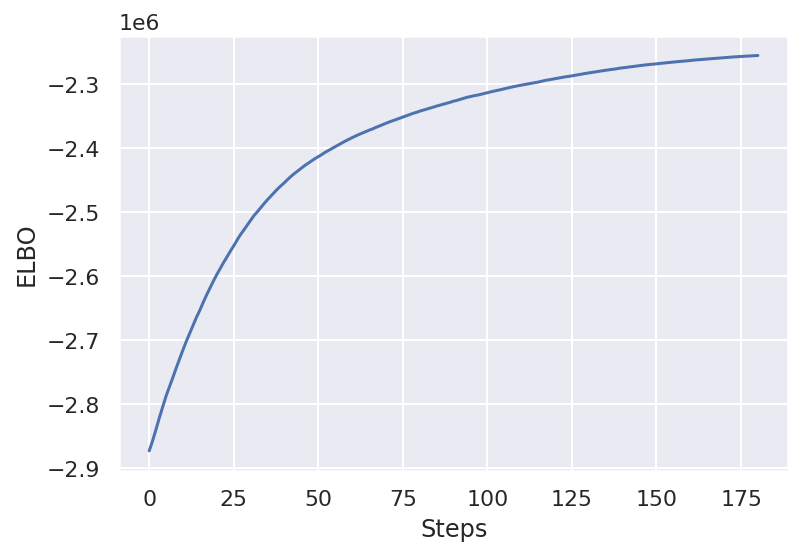

In [13]:
from analysis.MNIST_analysis.Pyro_BDA_MM_latent_analysis import MixedMembershipLatentAnalysis

data = data.permute(1, 0, 2)
MM = MixedMembershipLatentAnalysis(group_names, data, clean_names=names, 
                                   device="cuda:0", seed=0, num_components=6)

MM.fit_mm(plot_elbo=True, n_iterations=200)

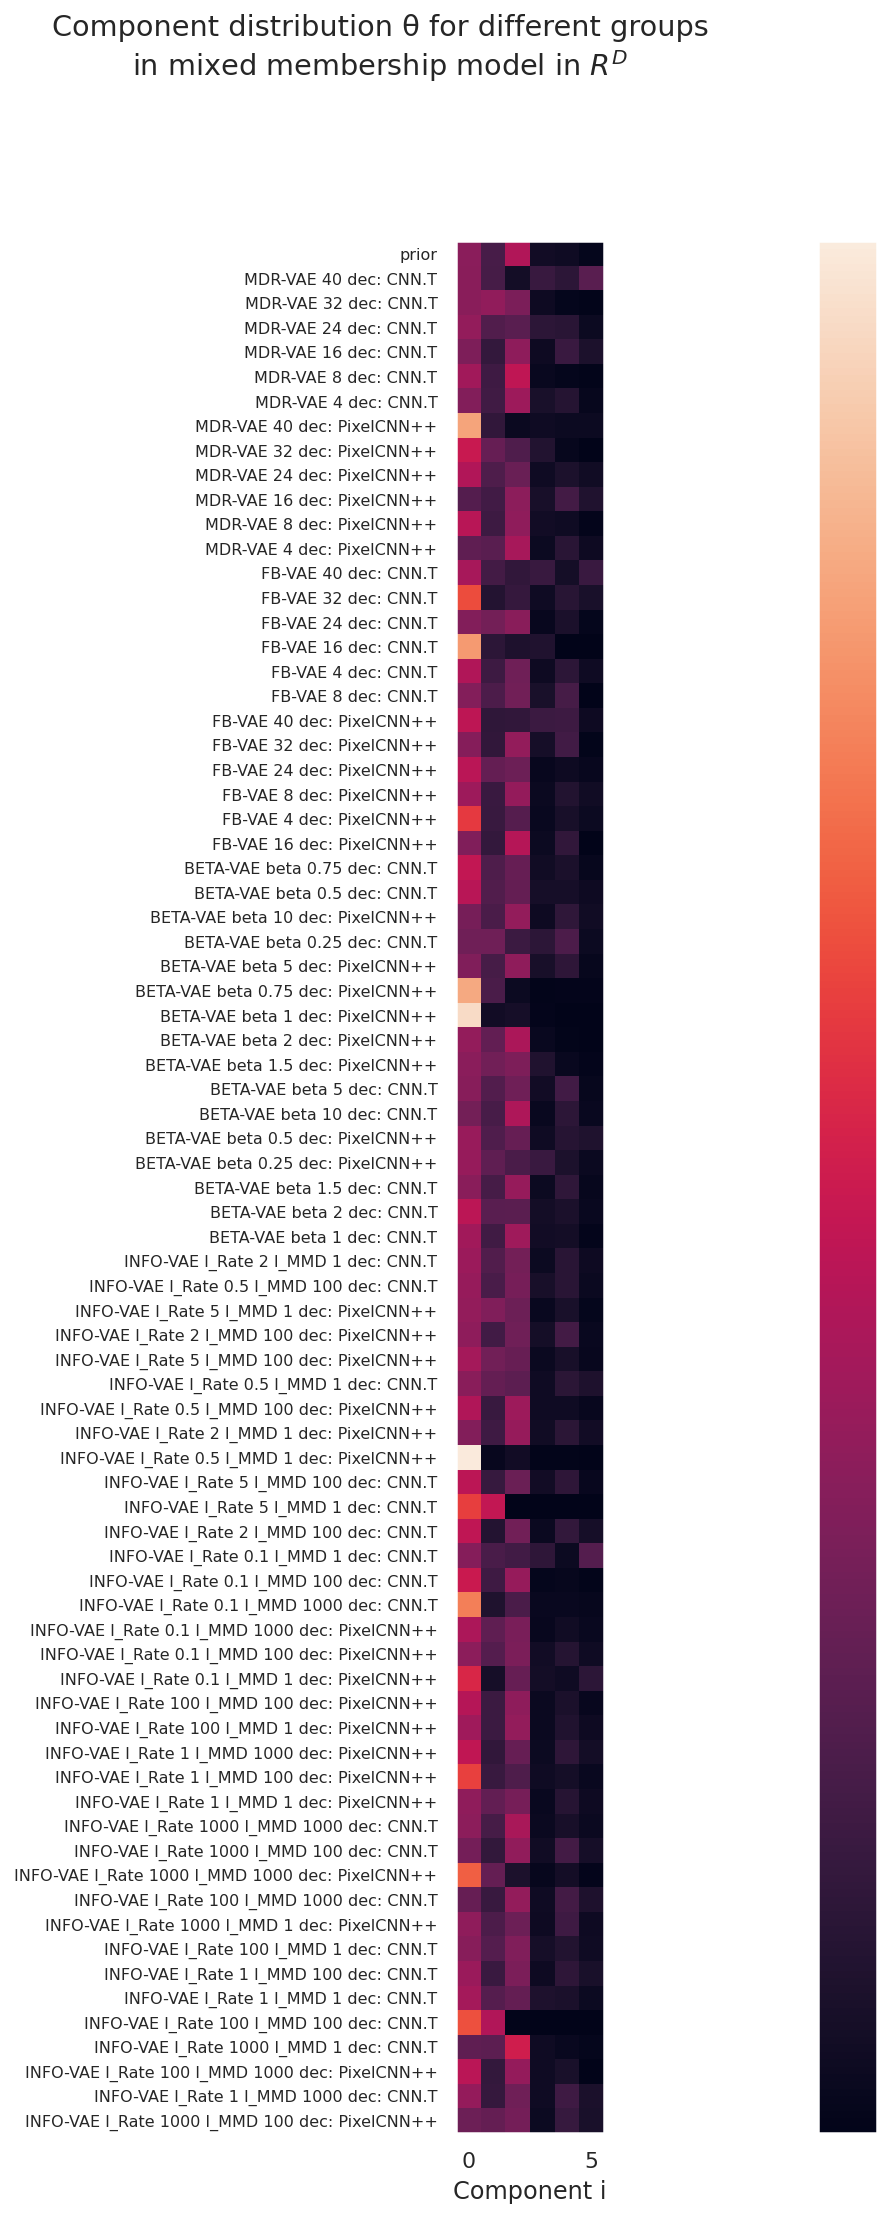

In [14]:
MM.plot_component_dist_groups(posterior_predict_n_samples=300)

In [15]:
marginal_kl = MM.approximate_marginal_kl()

In [16]:
marginal_kl_list = []

for g, name in enumerate(names):
    marginal_kl_list.append(marginal_kl[name])

Text(0.5, 1.0, 'R vs. MMD')

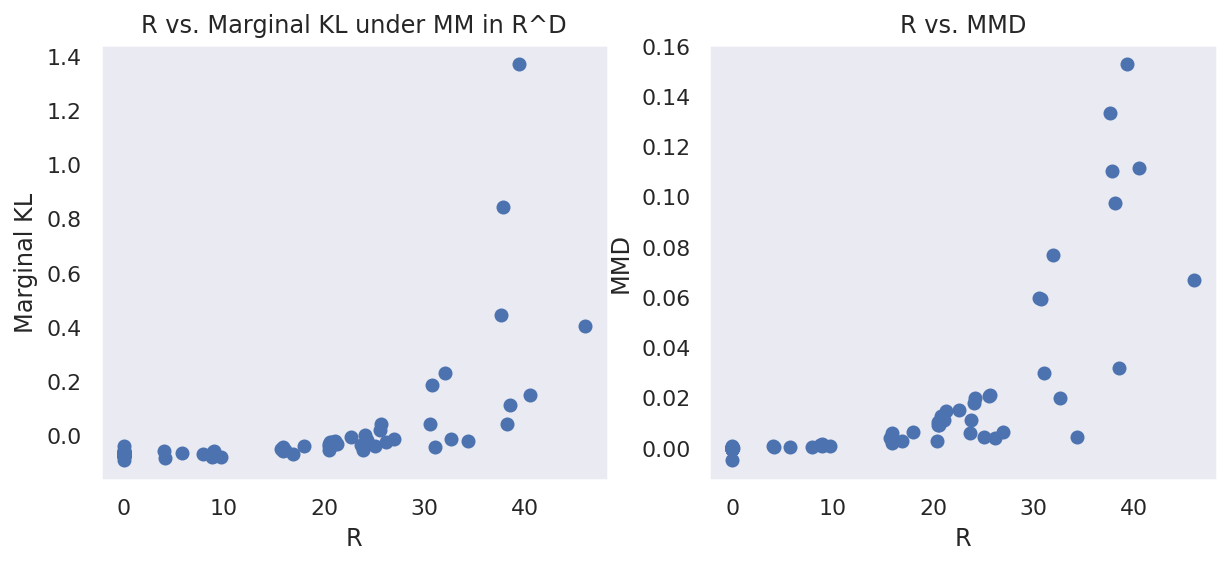

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

axs[0].scatter(rates, marginal_kl_list)
axs[0].set_xlabel("R")
axs[0].set_ylabel("Marginal KL")
axs[0].set_title("R vs. Marginal KL under MM in R^D")

axs[1].scatter(rates, mmd_stats)
axs[1].set_xlabel("R")
axs[1].set_ylabel("MMD")
axs[1].set_title("R vs. MMD")

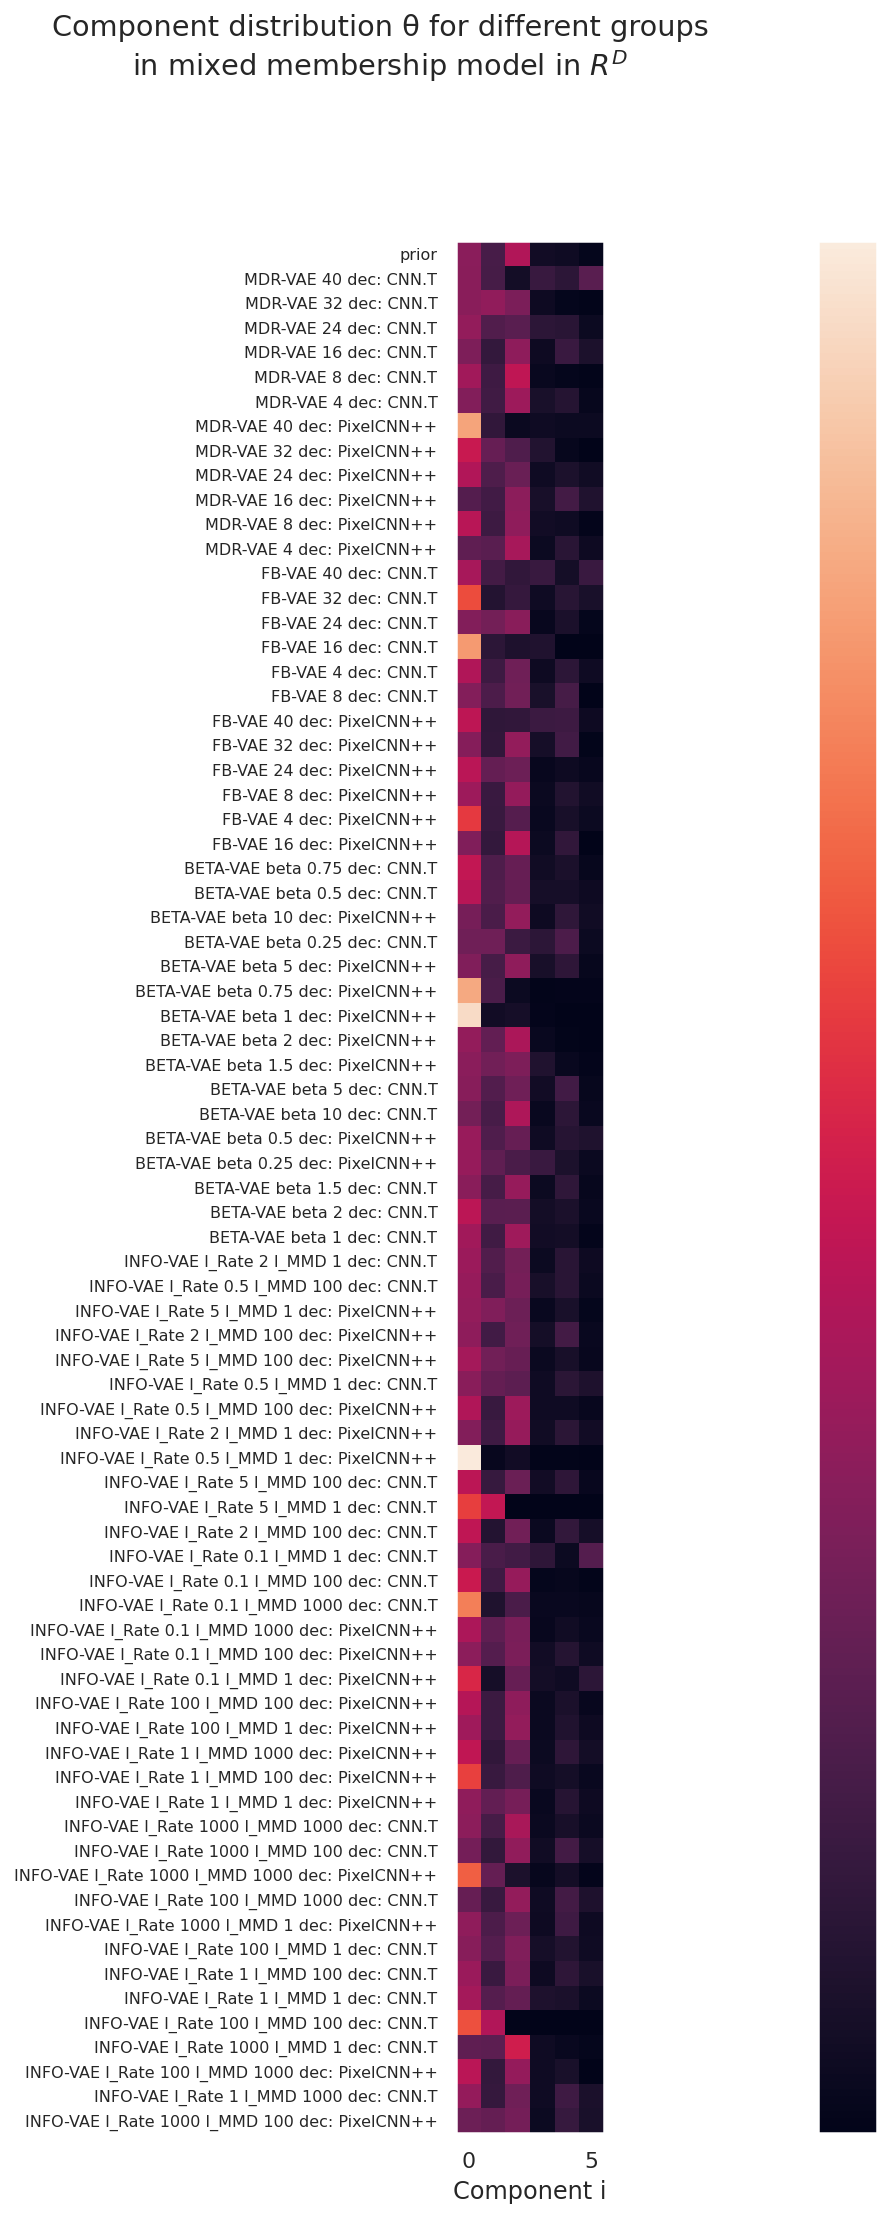

In [18]:
plot_component_dist_groups(MM)